# Interactive Jupyter notebook for hydrographic ocean data exploration, retrieval and visualization via the Argovis API


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Interactive-Jupyter-notebook-for-hydrographic-ocean-data-exploration,-retrieval-and-visualization-via-the-Argovis-API" data-toc-modified-id="Interactive-Jupyter-notebook-for-hydrographic-ocean-data-exploration,-retrieval-and-visualization-via-the-Argovis-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Interactive Jupyter notebook for hydrographic ocean data exploration, retrieval and visualization via the Argovis API</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Library-import" data-toc-modified-id="Library-import-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Library import</a></span></li></ul></li><li><span><a href="#Data-processing" data-toc-modified-id="Data-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data processing</a></span><ul class="toc-item"><li><span><a href="#Collecting-Data" data-toc-modified-id="Collecting-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Collecting Data</a></span></li><li><span><a href="#Formatting-Data" data-toc-modified-id="Formatting-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Formatting Data</a></span></li></ul></li><li><span><a href="#Data-visualizations" data-toc-modified-id="Data-visualizations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data visualizations</a></span><ul class="toc-item"><li><span><a href="#Plotting-metadata-on-a-map" data-toc-modified-id="Plotting-metadata-on-a-map-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plotting metadata on a map</a></span></li><li><span><a href="#Generate-property-plots" data-toc-modified-id="Generate-property-plots-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Generate property plots</a></span></li><li><span><a href="#Generate-scatter-plots" data-toc-modified-id="Generate-scatter-plots-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Generate scatter plots</a></span></li></ul></li><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Learning Objectives</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Setup

## Library import
These are some fundamental libraries that are very common in data analysis and visualization functions. Included below is a short description of each library and a link to its documentation for further reading. 
- `numpy`: a fundamental package for scientific computing
https://numpy.org/doc/stable/user/whatisnumpy.html
- `pandas`: package with various data anlysis methods and easy-to-use dataframes 
https://pandas.pydata.org/docs/#module-pandas 
- `datetime`: module for manipulating dates and times 
https://docs.python.org/3/library/datetime.html
- `matplotlib`: package with various visualization methods
https://matplotlib.org/
- `cartopy`: package designed for analyzing and visualizing geospatial data
https://scitools.org.uk/cartopy/docs/latest/
- `ipywidgets`: implement interactive widgets with Jupyter notebooks
https://ipywidgets.readthedocs.io/en/latest/

In [1]:
#data processing
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#data visualization
import matplotlib.pylab as plt
from matplotlib import colors
%matplotlib inline

#used for map projections
import cartopy.crs as ccrs

#widgets for user interaction
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')


# Data processing
The following functions are from the Argovis API notebook. Reference [this github repository](https://github.com/earthcube2020/ec20_tucker_etal) for further methods on data querying based on space/time selection. 

## Collecting Data
To query results from a specific space and time selection, the following Argo API functions will format your specifications into a URL that requests the data from the Argovis website and return a file with all of the data. 

The parameters that will be adjusted:
- `startDate`: string formatted as 'YYYY-MM-DD'
- `endDate`: string formatted as 'YYYY-MM-DD'
- `shape`: list of lists containing [lon, lat] coordinates
- `presRange`: a string of a list formatted as '[minimum pres,maximum pres]' (no spaces)
- `printUrl`: boolean (True/False option) that prints url output if equal to True

In [2]:
def get_selection_profiles(startDate, endDate, shape, presRange=None, printUrl=True):
    url = 'https://argovis.colorado.edu/selection/profiles'
    url += '?startDate={}'.format(startDate)
    url += '&endDate={}'.format(endDate)
    url += '&shape={}'.format(shape)
    if presRange:
        pressRangeQuery = '&presRange=' + presRange
        url += pressRangeQuery                         #compose URL with selection parameters
    if printUrl:
        print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    #if not resp.status_code // 100 == 2:
        #return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

## Formatting Data
In `parse_into_df()` the argument `profiles` will be the URL from the previous function. The given data file will be be cleaned and formatted into a dataframe with the following columns: 
- Pressure [dbar]
- Temperature [Celsius] 
- Salinity [psu]
- Cycle Number
- Profile ID
- Latitude
- Longitude
- Date of input

In [3]:
def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)      #create dataframe for profiles 
    for profile in profiles:                  #specify columns for profile measurements
        profileDf = pd.DataFrame(profile['measurements'])    
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

**Try it yourself:** Adjust the first four variables (shape, startDate, endDate, presRange) to query results from Argo data. This cell will return the URL to a page containing all of the metadata within your specified parameters. There are limits to how much data you can query at a time from the Argovis website, so if you get an error message try shortening the time period you specified.   

In [4]:
#options for regions to examine
south_coords = [[[-149.238281,-36.456636],[-141.879737,-37.077133],[-134.445218,-37.237608],
                 [-127.024817,-36.93345],[-119.707031,-36.173357],[-120.058594,-59.977005],
                 [-127.546527,-60.582449],[-135.216859,-60.756782],[-142.865732,-60.492308],
                 [-150.292969,-59.800634],[-149.238281,-36.456636]]]
gulf_coords = [[[-94.35249,27.365753],[-97.097603,24.402577],[-93.332877,20.489146],
                [-87.124507,22.099636],[-80.783791,23.47067],[-86.195584,29.161741],
                [-94.35249,27.365753]]]
pacific_coords = [[[164.355469,29.840644],[164.882812,-29.840644],[172.623113,-29.990522],
                   [-180,-29.701812],[-180,-29.701812],[-179.648438,-29.688053],
                   [179.648437,29.688053],[172.007811,29.985384],[164.355469,29.840644]]]
atlantic_coords = [[[-40.078125,29.840644],[-33.368671,30.338837],[-26.614528,30.492027],
                    [-19.863281,30.297018],[-20.039063,-30.145127],[-26.724822,-30.384017],
                    [-33.419918,-30.281826],[-40.078125,-29.840644],[-40.078125,29.840644]]]
labrador_coords = [[[-144.84375,36.031332],[-136.038755,36.210925],[-127.265625,35.746512],
                    [-128.144531,22.755921],[-136.543795,24.835311],[-145.195313,26.431228],
                    [-144.84375,36.031332]]]

In [6]:
#replace the following variables 
startDate='2020-4-10'
endDate='2020-4-29'
presRange ='[0,500]'
shape = labrador_coords

# do not change code below
strShape = str(shape).replace(' ', '')
selectionProfiles = get_selection_profiles(startDate, endDate, strShape, presRange)
selectionProfiles;

https://argovis.colorado.edu/selection/profiles?startDate=2020-4-10&endDate=2020-4-29&shape=[[[-144.84375,36.031332],[-136.038755,36.210925],[-127.265625,35.746512],[-128.144531,22.755921],[-136.543795,24.835311],[-145.195313,26.431228],[-144.84375,36.031332]]]&presRange=[0,500]


Here we are checking that our data file is not empty then calling `parse_into_df` to create a data frame out of the values found in the file. Then to complete the data cleaning process, we replace all occurences of -999, which is a placeholder value for null or missing values in the data, with the null keyword: NaN. This is crucial to the data cleaning step because we do not want these large negative values to affect our data analysis and/or skew our visualizations. 

In [7]:
if len(selectionProfiles) > 0:                            
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)           #replace -999 with NaN

Below is all of the data cleaned and formatted properly. 

In [8]:
selectionDf = parse_into_df(selectionProfiles)
selectionDf['year'] = pd.DatetimeIndex(selectionDf['date']).year
selectionDf['month'] = pd.DatetimeIndex(selectionDf['date']).month
selectionDf['day'] = pd.DatetimeIndex(selectionDf['date']).day
selectionDf

,pres,psal,temp,cycle_number,profile_id,lat,lon,date,year,month,day
0,1.08,32.918,15.815,81.0,4903010_81,32.73155,-129.16509,2020-04-28T23:47:28.320Z,2020,4,28
1,2.00,32.921,15.777,81.0,4903010_81,32.73155,-129.16509,2020-04-28T23:47:28.320Z,2020,4,28
2,3.04,32.932,15.665,81.0,4903010_81,32.73155,-129.16509,2020-04-28T23:47:28.320Z,2020,4,28
3,4.04,32.918,15.426,81.0,4903010_81,32.73155,-129.16509,2020-04-28T23:47:28.320Z,2020,4,28
4,5.00,32.902,15.338,81.0,4903010_81,32.73155,-129.16509,2020-04-28T23:47:28.320Z,2020,4,28
...,...,...,...,...,...,...,...,...,...,...,...
251,491.96,33.978,6.094,35.0,4903017_35,34.63517,-142.44692,2020-04-10T03:58:14.016Z,2020,4,10
252,494.00,33.977,6.072,35.0,4903017_35,34.63517,-142.44692,2020-04-10T03:58:14.016Z,2020,4,10
253,496.04,33.979,6.057,35.0,4903017_35,34.63517,-142.44692,2020-04-10T03:58:14.016Z,2020,4,10
254,497.96,33.978,6.044,35.0,4903017_35,34.63517,-142.44692,2020-04-10T03:58:14.016Z,2020,4,10


Here are the number of observations and floats recorded in your dataset. 

In [9]:
print('Number of recorded observations: ' + str(len(selectionDf)))
print('Number of profiles: ' + str(len(np.unique(selectionDf['profile_id']))))

Number of recorded observations: 8808
Number of profiles: 41


# Data visualizations

## Plotting metadata on a map
This function will take the coordinates from the profiles in your selection dataframe and plot them onto a map. Use this to reference how many floats are in your selection and predict what kind of temperature and salinity values you might see in the next step.

**Try it yourself:** Explore the functionality of the previous methods by experimenting with your selection parameters. 

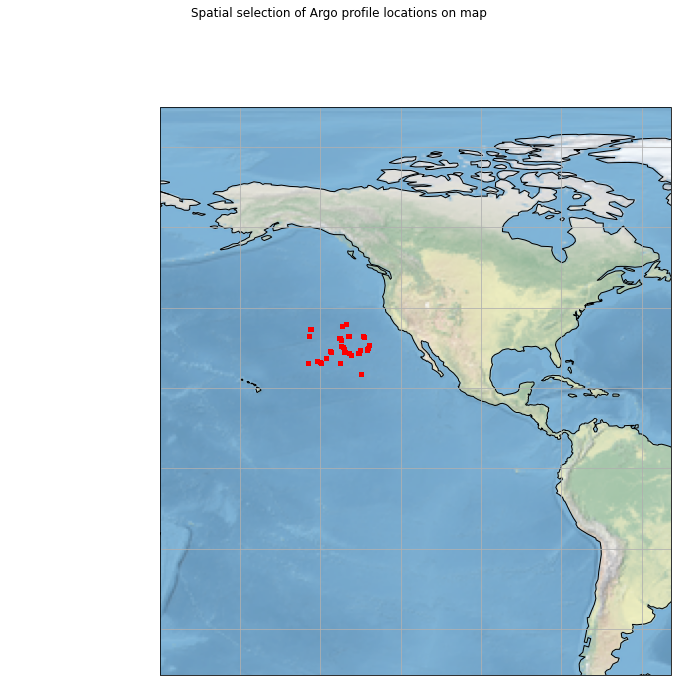

In [10]:
def plot_pmesh(figsize=(12,12), shrinkcbar=.1, delta_lon=75, delta_lat=75, \
               map_proj=ccrs.PlateCarree(), xlims=None):
    df = selectionDf
    fig = plt.figure(figsize=figsize)
    
    #collect lon, lat values to create coordinates
    x = df['lon'].values                   
    y = df['lat'].values
    points = map_proj.transform_points(ccrs.Geodetic(), x, y)
    x = points[:, 0]
    y = points[:, 1]
    
    #plot coordinates
    map_proj._threshold /= 100
    ax = plt.axes(projection=map_proj, xlabel='long', ylabel='lats')
    ax.set_global()
    plt.title('Spatial selection of Argo profile locations on map')
    sct = plt.scatter(x, y, c='r', s=15,zorder=3) 
    
    #specify boundaries for map plot
    if not xlims:
        xlims = [df['lon'].max() + delta_lon, df['lon'].min()- delta_lon]
    ax.set_xlim(min(xlims), max(xlims))
    ax.set_ylim(min(df['lat']) - delta_lat, max(df['lat']) + delta_lat)
    
    ax.coastlines(zorder=1)
    ax.stock_img()
    ax.gridlines()
    return fig

# run function 
map_viz = plot_pmesh()

## Generate property plots
To visualize relationships between profile measurements, we can plot features in a property plot. Each line is specified by `z_col` which can be any of the following: 
- `profile_id`
- `date (day, year, or month)`

In [15]:
#options for drop-drown menus
x = [('Temperature', 'temp'),('Pressure', 'pres'),('Salinity', 'psal'),('Longitude', 'lon'),('Latitude', 'lat')]
y = [('Pressure', 'pres'),('Temperature', 'temp'),('Salinity', 'psal')]
z = [('Profile ID', 'profile_id'),('Day', 'day'), ('Year', 'year'), ('Month', 'month')]

#initialize widgets
x_drop = widgets.Dropdown(options=x, val='Temperature', description='X-variable', disabled=False)
y_drop = widgets.Dropdown(options=y, val='Pressure', description='Y-variable', disabled=False)
z_drop = widgets.Dropdown(options=z, val='Profile ID', description='Z-variable', disabled=False)
widgets.VBox([x_drop, y_drop, z_drop])

unit_dict = {'pres':'Pressure [dbar]', 'temp': 'Temperature [Celsius]', 'psal':'Salinity [psu]', 'date' : 'Date', 'lat':'Latitude','lon':'Longitude'}
def property_plot_selection(x_col, y_col, z_col):
    print('Recalculating....')
    fig, ax = plt.subplots()
    
    #group lines by z-variable
    for key, group in selectionDf.groupby([z_col]):
        ax = group.plot(ax=ax, kind='line', x=x_col, y=y_col, label=key, figsize=(15,10), alpha=0.5, legend =None)
    if z_col != 'profile_id':
        ax.legend(bbox_to_anchor=(1.1, 1.05))
    
    #inverse y-axis if pressure is chosen
    if y_col == 'pres':
        ax.set_ylim(ax.get_ylim()[::-1])
    
    #generate plot
    ax.set_title(unit_dict[x_col].split(' ')[0]+ ' vs. ' +unit_dict[y_col].split(' ')[0] + ' Argo profiles')
    ax.set_xlabel(unit_dict[x_col])
    ax.set_ylabel(unit_dict[y_col])

**Try it yourself:** Use the dropdown menus below to graph your x, y and z columns. Here are a few suggestions to practice visualizing your data: 
- Temperature vs. pressure
- Salinity vs. pressure
- Salinity vs. temperature

<div class="alert alert-block alert-danger">
    <b>Warning</b>: If a KeyError occurs in the following cell, make sure your X and Y variables are not the same then re-run the cell. 
</div>


In [16]:
plot_shape = widgets.interact(property_plot_selection, x_col=x_drop, y_col=y_drop, z_col=z_drop)
plot_shape;

interactive(children=(Dropdown(description='X-variable', options=(('Temperature', 'temp'), ('Pressure', 'pres'…

## Generate scatter plots

For this graph we will be plotting the relationship between time or location vs. pressure and the points are color-coded by adjustable temperature/salinity intervals. 

In [13]:
#options for drop-drown menus
x_option = [('Time', 'date'),('Longitude', 'lon'),('Latitude', 'lat')]
z_option = [('Temperature', 'temp'),('Salinity', 'psal')]

x_pick = widgets.Dropdown(options=x_option, val='Time', description='X-variable', disabled=False)
z_pick = widgets.Dropdown(options=z_option, val='Temperature', description='Z-variable', disabled=False)

widgets.VBox([x_pick, z_pick])
def scatter_plot_selection(x_col, z_col, num_ints, y_col='pres'):
    print('Recalculating....')
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)

    c_step = (max(selectionDf[z_col])-min(selectionDf[z_col]))/num_ints
    cmap = plt.cm.rainbow
    norm = colors.BoundaryNorm(np.arange(min(selectionDf[z_col]), max(selectionDf[z_col]), c_step), cmap.N)

    #group lines by z-variable
    plt.scatter(selectionDf[x_col], selectionDf[y_col], c=selectionDf[z_col], cmap=cmap, s=50, norm=norm)
    plt.colorbar(ticks=np.linspace(max(selectionDf[z_col])+1, min(selectionDf[z_col]), num_ints+1))

    #inverse y-axis for pressure
    ax.set_ylim(ax.get_ylim()[::-1])
    
    #generate plot
    ax.set_title(unit_dict[x_col].split(' ')[0]+ ' vs. Pressure Argo profiles')
    ax.set_xlabel(unit_dict[x_col])
    plt.xticks([])
    ax.set_ylabel('Pressure [dbar]')

**Try it yourself**: Use the drop down menues to specify your X- and Y- variables. Use the slider with label 'num_ints' to specify the number of intervals for your colorbar; make sure the value is greater than 1. 

In [14]:
scatter_shape = widgets.interact(scatter_plot_selection, x_col=x_pick, z_col=z_pick, num_ints=10)
scatter_shape;

interactive(children=(Dropdown(description='X-variable', options=(('Time', 'date'), ('Longitude', 'lon'), ('La…

# Learning Objectives
**Answer these questions after experimenting with the functions.**

a.) Describe your study region. Would you best describe your region as polar, subpolar, or tropical? 

b.) What is a mix-layer? Would you expect shallow or deep mix-layers in your study region? 

c.) With the property plot function, plot temperature vs pressure. What is the mix layer depth? Does it vary in time? If so, how?

d.) Now plot salinity vs pressure, do any of your above answers change. Why or why not? 

e.) Now, pick a different region in the ocean and repeat questions a - d. How is this region different or the same?

# References

1. Argovis background: Tucker, T., Giglio, D., Scanderbeg, M., & Shen, S. S. P. (2020). Argovis: A Web Application for Fast Delivery, Visualization, and Analysis of Argo Data, Journal of Atmospheric and Oceanic Technology, 37(3), 401-416. Retrieved May 14, 2021, from https://journals.ametsoc.org/view/journals/atot/37/3/JTECH-D-19-0041.1.xml
2. Argovis website: https://argovis.colorado.edu/
3. Argovis API notebook: https://github.com/earthcube2020/ec20_tucker_etal 
4. Jupyter widgets documentation: https://ipywidgets.readthedocs.io/en/latest/
5. Jupyter notebooks featured at Earthcube 2020 Annual meeting: https://www.earthcube.org/notebooks